In [129]:
# ======================
# IMPORT LIBRARIES
# ======================
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, HeatMap
from branca.element import Template, MacroElement
import geopandas as gpd
import contextily as ctx
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from geopy.distance import geodesic
from shapely.geometry import Point, LineString
import osmnx as ox
import networkx as nx



In [130]:

# ======================
# DATA LOADING & INITIAL EXPLORATION
# ======================
df = pd.read_excel("Survey_Data.xlsx")

# Initial data inspection
df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 19 columns):
 #   Column                                                                                                                Non-Null Count  Dtype         
---  ------                                                                                                                --------------  -----         
 0   Timestamp                                                                                                             151 non-null    datetime64[ns]
 1   Gender                                                                                                                151 non-null    object        
 2   Age                                                                                                                   151 non-null    object        
 3   what is your home state                                                                                               15

In [131]:


# ======================
# DATA CLEANING
# ======================
# Function to clean longitude and latitude
def clean_coordinates(coord_series):
    return coord_series.str.replace('°', '', regex=True).str.replace('N', '', regex=True).str.replace('E', '', regex=True)

# Apply cleaning to coordinates
df["Latitude"] = clean_coordinates(df["Latitude"])
df["Longitude"] = clean_coordinates(df["Longitude"])


In [132]:

# Convert to float and verify
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)


In [133]:

# Check for missing values
df.isnull().sum()


Timestamp                                                                                                               0
Gender                                                                                                                  0
Age                                                                                                                     0
what is your home state                                                                                                 0
what is your local government area(LGA)                                                                                 0
what was the location of your secondary school?(name of town or city)                                                   0
Latitude                                                                                                                0
Longitude                                                                                                               0
How many times did you a

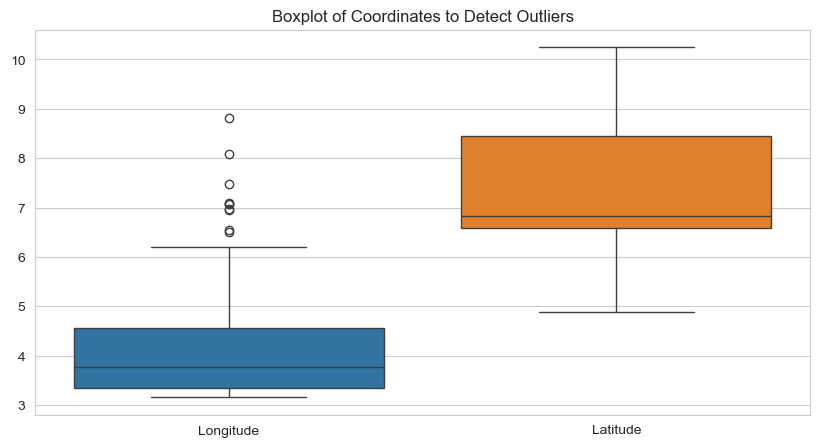

In [134]:

# Check for outliers in numerical columns
plt.figure(figsize=(10,5))
sns.boxplot(data=df[["Longitude", "Latitude"]])
plt.title("Boxplot of Coordinates to Detect Outliers")
plt.show()


In [135]:

# Define the IQR range for longitude
Q1 = df["Longitude"].quantile(0.25)
Q3 = df["Longitude"].quantile(0.75)
IQR = Q3 - Q1


In [136]:

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = df[(df["Longitude"] < lower_bound) | (df["Longitude"] > upper_bound)]
print(outliers)


                  Timestamp  Gender       Age what is your home state   \
4   2025-03-28 16:31:12.443    Male     23-27                     Kogi   
6   2025-03-28 16:34:54.550  Female     18-22                    Kwara   
38  2025-03-28 17:29:07.069    Male     18-22                      FCT   
39  2025-03-28 17:30:55.585    Male  Under 18                    Delta   
56  2025-03-28 19:44:25.019    Male     18-22                    Kwara   
97  2025-03-29 10:23:41.718    Male     23-27                      Imo   
123 2025-03-29 16:11:24.169    Male     23-27                    Enugu   
124 2025-03-29 16:13:08.672    Male     23-27                   Rivers   
146 2025-03-30 07:08:05.417    Male     23-27                     FCT    
149 2025-03-30 07:12:28.667  Female     23-27                 Plateau    

    what is your local government area(LGA)  \
4                                  Ajeokuta   
6                                   Oke ero   
38                                     Karu 

In [137]:


# ======================
# COORDINATE CORRECTIONS
# ======================
# 1. Fix Abakaliki coordinates (convert to negative longitude if confirmed to be west)
df.loc[df['what was the location of your secondary school?(name of town or city)'].str.contains('Abakaliki', case=False, na=False), 
       'Longitude'] = -8.0763  # Use 8.0763 if confirmed East

# 2. Adjust Port Harcourt coordinates (approximate correct location)
df.loc[df['what was the location of your secondary school?(name of town or city)'].str.contains('port harcourt', case=False, na=False), 
       ['Latitude', 'Longitude']] = [4.8156, 7.0498]  # Central PH coordinates

# 3. Verify Jengre (no automatic fix - flag for review)
jengre_mask = df['what was the location of your secondary school?(name of town or city)'].str.contains('Jengre', case=False, na=False)
print("Rows needing manual verification for Jengre:")
print(df[jengre_mask][['what was the location of your secondary school?(name of town or city)', 'Latitude', 'Longitude']])

# 4. Correct Gwawalada to Gwagwalada
df['what was the location of your secondary school?(name of town or city)'] = df['what was the location of your secondary school?(name of town or city)'].str.replace('Gwawalada', 'Gwagwalada', case=False)

# Save corrected dataset
df.to_csv("corrected_schools_data.csv", index=False)
print("Corrections applied and saved")



Rows needing manual verification for Jengre:
    what was the location of your secondary school?(name of town or city)  \
149                                            Jengre                       

     Latitude  Longitude  
149   10.2452     8.8105  
Corrections applied and saved


In [138]:
from geopy.distance import geodesic

# University of Ilorin coordinates
uni_coords = (8.4790, 4.6710)

# Function to calculate distance
def calculate_distance(lat, lon):
    return geodesic((lat, lon), uni_coords).km

# Apply function
df['Home_to_Uni_Distance'] = df.apply(lambda row: calculate_distance(row['Latitude'], row['Longitude']), axis=1)

In [139]:

# ======================
# COLUMN STANDARDIZATION
# ======================
# Standardizing column names for consistency
df.rename(columns={
    'what is your home state ': 'Home_State',
    'what is your local government area(LGA)': 'LGA',
    'what was the location of your secondary school?(name of town or city)': 'Secondary_School_Location',
    'What is the approximate distance between your home and the University of Ilorin?  ': 'Distance_to_uni'
}, inplace=True)



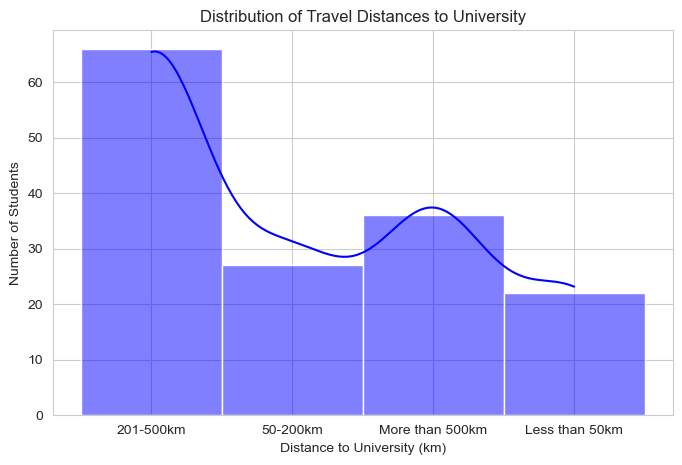

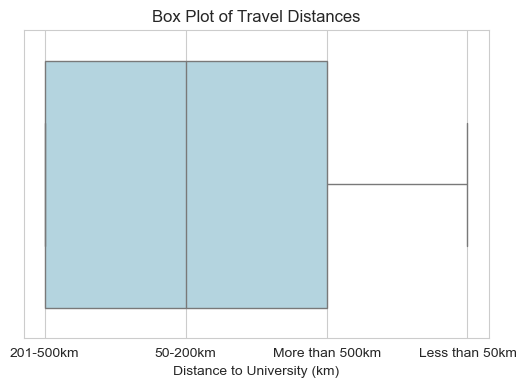

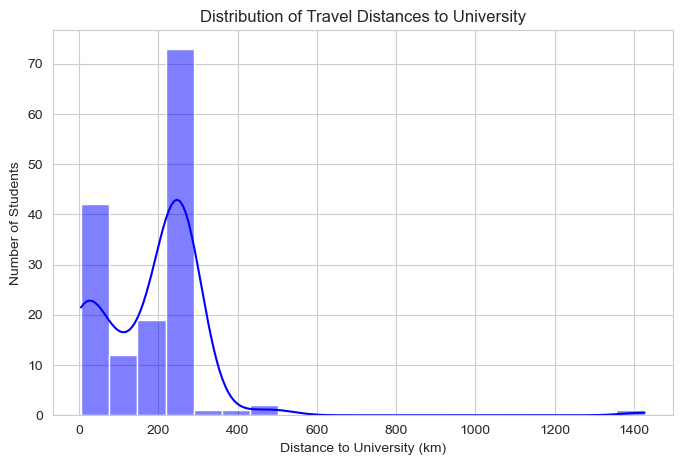

Visualizations saved to Final_Visualization folder:
['cluster_distance_comparison.png', 'dbscan_cluster_analysis.png', 'distance_boxplot.png', 'distance_histogram.png', 'home_to_uni_histogram.png', 'student_map_with_legend.html']


In [140]:
# ======================
# VISUALIZATIONS
# ======================
import os

# Create visualization folder if it doesn't exist
os.makedirs("Final_Visualization", exist_ok=True)

# Set style for better visualization
sns.set_style("whitegrid")

# Histogram of distances
plt.figure(figsize=(8, 5))
sns.histplot(df["Distance_to_uni"], bins=4, kde=True, color="blue")
plt.xlabel("Distance to University (km)")
plt.ylabel("Number of Students")
plt.title("Distribution of Travel Distances to University")
plt.savefig("Final_Visualization/distance_histogram.png", dpi=300, bbox_inches='tight')
plt.show()

# Box plot to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Distance_to_uni"], color="lightblue")
plt.xlabel("Distance to University (km)")
plt.title("Box Plot of Travel Distances")
plt.savefig("Final_Visualization/distance_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Histogram of home to uni distances
plt.figure(figsize=(8, 5))
sns.histplot(df['Home_to_Uni_Distance'], kde=True, bins=20, color='blue')
plt.xlabel("Distance to University (km)")
plt.ylabel("Number of Students")
plt.title("Distribution of Travel Distances to University")
plt.savefig("Final_Visualization/home_to_uni_histogram.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved to Final_Visualization folder:")
print(os.listdir("Final_Visualization"))

In [141]:
df.columns

Index(['Timestamp', 'Gender', 'Age', 'Home_State', 'LGA',
       'Secondary_School_Location', 'Latitude', 'Longitude',
       'How many times did you attempt JAMB before gaining admission?',
       'Did you have to relocate from your home state to attend the University of Ilorin? ',
       'Distance_to_uni',
       'What is your estimated annual tuition and school-related expenses? ',
       'How do you fund your university education? ',
       'Have you ever had to defer a semester due to financial difficulties? ',
       'What challenges do you face in accessing learning materials?  ',
       'Does your department have adequate classrooms and lecture halls? ',
       'Do you have access to a stable power supply for studying?  ',
       'Do you believe students from rural areas face more difficulties accessing university education than urban students? ',
       'What do you think is the biggest barrier to university education in Nigeria?  ',
       'Home_to_Uni_Distance'],
      dtype

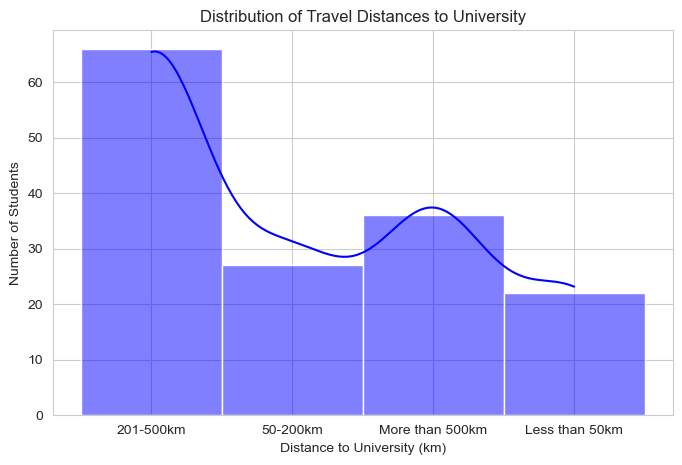

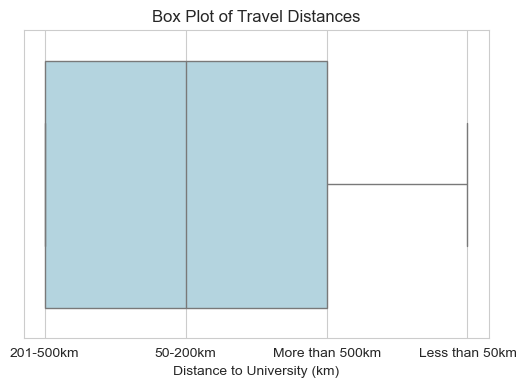

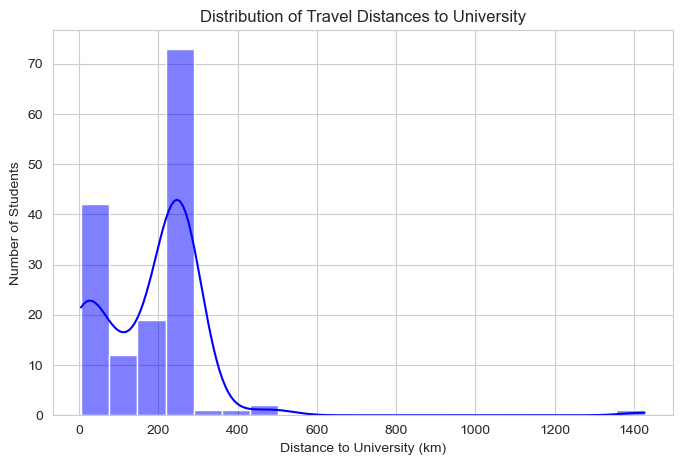

In [142]:


# ======================
# VISUALIZATIONS
# ======================
# Set style for better visualization
sns.set_style("whitegrid")

# Histogram of distances
plt.figure(figsize=(8, 5))
sns.histplot(df["Distance_to_uni"], bins=4, kde=True, color="blue")
plt.xlabel("Distance to University (km)")
plt.ylabel("Number of Students")
plt.title("Distribution of Travel Distances to University")
plt.show()

# Box plot to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Distance_to_uni"], color="lightblue")
plt.xlabel("Distance to University (km)")
plt.title("Box Plot of Travel Distances")
plt.show()

# Histogram of home to uni distances
plt.figure(figsize=(8, 5))
sns.histplot(df['Home_to_Uni_Distance'], kde=True, bins=20, color='blue')
plt.xlabel("Distance to University (km)")
plt.ylabel("Number of Students")
plt.title("Distribution of Travel Distances to University")
plt.show()



c:\Users\Abubakar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


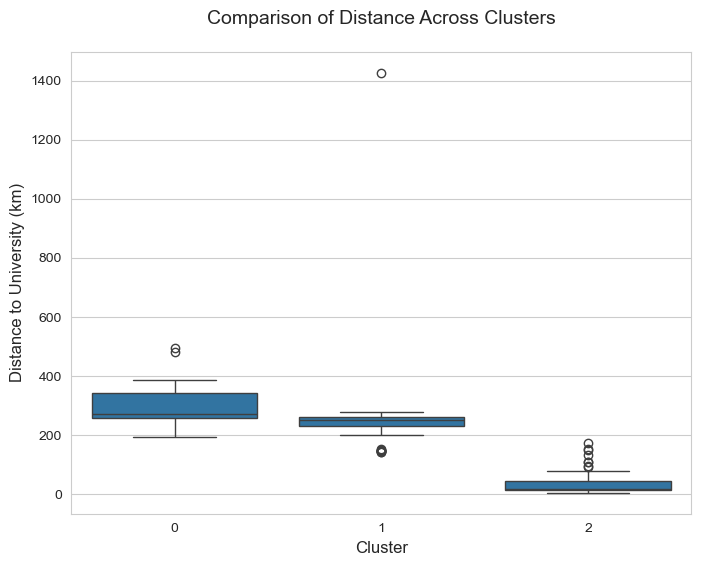

Cluster analysis visualization saved to:
Final_Visualization/cluster_distance_comparison.png


In [143]:
# ======================
# CLUSTERING ANALYSIS
# ======================
# Create visualization folder if it doesn't exist
import os
os.makedirs("Final_Visualization", exist_ok=True)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

# Boxplot of distance across clusters
plt.figure(figsize=(8, 6))  # Added figure size for better proportions
sns.boxplot(x=df['Cluster'], y=df['Home_to_Uni_Distance'])
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Distance to University (km)", fontsize=12)
plt.title("Comparison of Distance Across Clusters", fontsize=14, pad=20)

# Save the plot
plt.savefig("Final_Visualization/cluster_distance_comparison.png", 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')  # Ensures white background

plt.show()

print("Cluster analysis visualization saved to:")
print("Final_Visualization/cluster_distance_comparison.png")

In [144]:

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.2, min_samples=5)  # Try 0.2 or 0.3
df["DBSCAN_Cluster"] = dbscan.fit_predict(df[['Latitude', 'Longitude']])



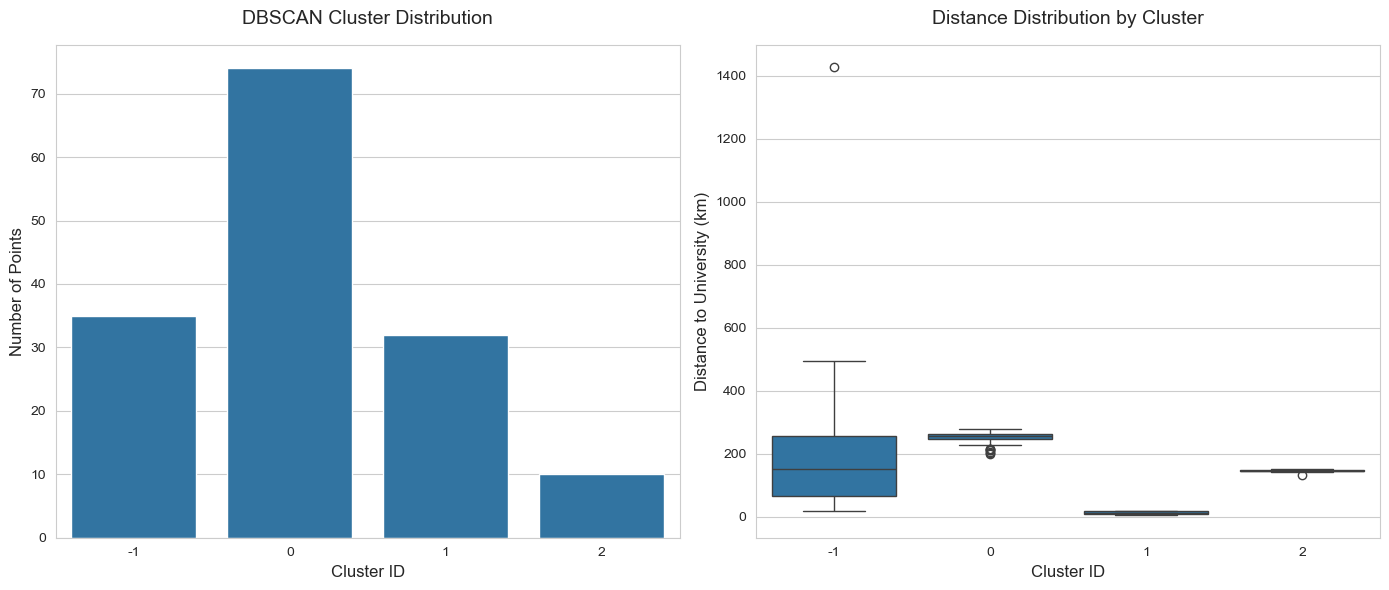


DBSCAN identified 3 clusters (excluding noise)
Visualization saved to: Final_Visualization/dbscan_cluster_analysis.png
Cluster counts:
DBSCAN_Cluster
-1    35
 0    74
 1    32
 2    10
Name: count, dtype: int64


In [126]:
# ======================
# DBSCAN CLUSTERING VISUALIZATION
# ======================
# Create visualization folder if it doesn't exist
import os
os.makedirs("Final_Visualization", exist_ok=True)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.2, min_samples=5)  # Try 0.2 or 0.3
df["DBSCAN_Cluster"] = dbscan.fit_predict(df[['Latitude', 'Longitude']])

# Create figure with two subplots
plt.figure(figsize=(14, 6))

# Plot 1: DBSCAN Cluster Distribution
plt.subplot(1, 2, 1)
sns.countplot(x=df['DBSCAN_Cluster'])
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Number of Points", fontsize=12)
plt.title("DBSCAN Cluster Distribution", fontsize=14, pad=15)

# Plot 2: Boxplot of distances per cluster
plt.subplot(1, 2, 2)
sns.boxplot(x=df['DBSCAN_Cluster'], y=df['Home_to_Uni_Distance'])
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Distance to University (km)", fontsize=12)
plt.title("Distance Distribution by Cluster", fontsize=14, pad=15)

# Adjust layout and save
plt.tight_layout()
plt.savefig("Final_Visualization/dbscan_cluster_analysis.png", 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')

plt.show()

# Print cluster information
n_clusters = len(df['DBSCAN_Cluster'].unique()) - 1  # Excluding noise (-1)
print(f"\nDBSCAN identified {n_clusters} clusters (excluding noise)")
print("Visualization saved to: Final_Visualization/dbscan_cluster_analysis.png")
print("Cluster counts:")
print(df['DBSCAN_Cluster'].value_counts().sort_index())

In [116]:

# ======================
# SPATIAL VISUALIZATIONS
# ======================
# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [117]:

# Convert to Web Mercator for basemap
gdf = gdf.to_crs(epsg=3857)


KeyError: 'Cluster'

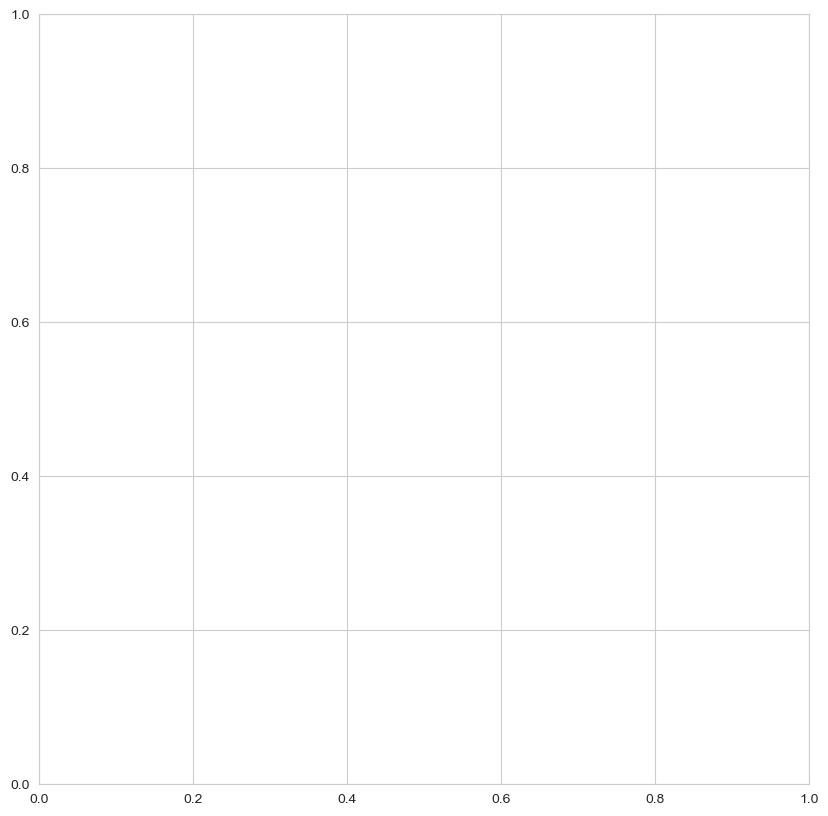

In [145]:

# Plot clusters
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, column='Cluster', categorical=True, 
         legend=True, markersize=50, alpha=0.7, cmap='tab20')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Spatial Distribution of Student Clusters', fontsize=16)
ax.set_axis_off()
plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Create the map centered around University of Ilorin
m = folium.Map(location=[8.4799, 4.5418], zoom_start=6)

# Add a marker for University of Ilorin
folium.Marker(
    location=[8.4799, 4.5418],
    popup="University of Ilorin",
    icon=folium.Icon(color='red', icon='graduation-cap')
).add_to(m)

# Add markers for student locations
marker_cluster = MarkerCluster().add_to(m)
for _, row in df.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=row["Secondary_School_Location"],
        icon=folium.Icon(color='blue', icon='user')
    ).add_to(marker_cluster)

# Custom legend template
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 200px;
    background-color: white;
    z-index:9999;
    padding: 10px;
    border-radius: 5px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
    font-size: 14px;
">
    <b>Legend</b><br>
    <i class="fa fa-map-marker fa-2x" style="color:red"></i> University of Ilorin<br>
    <i class="fa fa-map-marker fa-2x" style="color:blue"></i> Student Locations<br>
</div>
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Show map
m.save("student_map_with_legend.html")


In [ ]:


# ======================
# SPATIAL ANALYSIS
# ======================
# Moran's I for spatial autocorrelation
from esda.moran import Moran
from libpysal.weights import DistanceBand

# Create spatial weights matrix
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
weights = DistanceBand(coords, threshold=50000)  # 50km threshold


c:\Users\Abubakar\anaconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 9 islands with ids: 6, 38, 39, 55, 97, 123, 124, 129, 149.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\Abubakar\anaconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 9 islands with ids: 6, 38, 39, 55, 97, 123, 124, 129, 149.
  W.__init__(


In [ ]:

# Calculate Moran's I for distance to university
moran = Moran(gdf['Home_to_Uni_Distance'], weights)
print(f"Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_norm:.3f}")

# Interpretation
if moran.p_norm < 0.05:
    if moran.I > 0:
        print("Significant spatial clustering (similar values attract)")
    else:
        print("Significant spatial dispersion (similar values repel)")
else:
    print("Random spatial pattern")


('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 55, ' is an island (no neighbors)')
('WARNING: ', 97, ' is an island (no neighbors)')
('WARNING: ', 123, ' is an island (no neighbors)')
('WARNING: ', 124, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
Moran's I: 0.495
P-value: 0.000
Significant spatial clustering (similar values attract)


In [ ]:

# Silhouette Score for clustering validation
X = gdf[['Home_to_Uni_Distance', 'Latitude', 'Longitude']]
X_scaled = StandardScaler().fit_transform(X)

score = silhouette_score(X_scaled, gdf['Cluster'])
print(f"Silhouette Score: {score:.3f}")

# Interpretation guide
if score > 0.7:
    print("Strong cluster structure")
elif score > 0.5:
    print("Reasonable cluster structure")
elif score > 0.25:
    print("Weak cluster structure")
else:
    print("No substantial cluster structure")



Silhouette Score: 0.683
Reasonable cluster structure


In [ ]:

# ======================
# NETWORK ANALYSIS
# ======================
# Load road data
roads = gpd.read_file("Nigerian_Roads_Data")


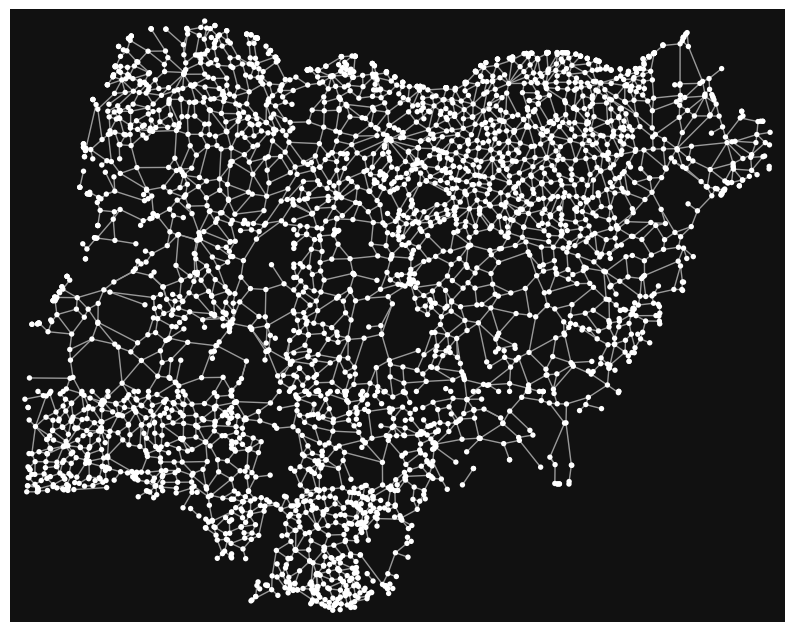

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [ ]:

# Create graph structure
G = nx.MultiDiGraph()

# Add nodes from all road endpoints
node_coords = set()
for _, row in roads.iterrows():
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        node_coords.update([coords[0], coords[-1]])

# Add nodes to graph
for i, coord in enumerate(node_coords):
    G.add_node(i, x=coord[0], y=coord[1], osmid=i)

# Add edges (roads) between nodes
coord_to_id = {coord: i for i, coord in enumerate(node_coords)}
for _, row in roads.iterrows():
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        u = coord_to_id[coords[0]]
        v = coord_to_id[coords[-1]]
        attr = row.drop('geometry').to_dict()
        G.add_edge(u, v, **attr)

# Add graph properties
G.graph['crs'] = roads.crs

# Calculate edge lengths
for u, v, data in G.edges(data=True):
    point1 = Point(G.nodes[u]['x'], G.nodes[u]['y'])
    point2 = Point(G.nodes[v]['x'], G.nodes[v]['y'])
    data['length'] = point1.distance(point2)

# Plot
ox.plot_graph(G, figsize=(10, 10))


In [ ]:


# ======================
# JAMB ATTEMPTS ANALYSIS
# ======================
# Define the mapping dictionary
jamb_attempts_mapping = {
    "First attempt": 1,
    "Second attempt": 2,
    "Third attempt": 3,
    "More than three attempts": 4
}


In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd
import numpy as np

    


In [146]:
# 1. First clean your data properly
def clean_data(df):
    """Clean and prepare the dataframe for visualization"""
    # Ensure coordinates are numeric
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
    df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
    
    # Remove rows with invalid coordinates
    df = df.dropna(subset=['Latitude', 'Longitude'])
    
    # Convert JAMB attempts to numeric
    df['JAMB_Attempts_Numeric'] = pd.to_numeric(
        df['How many times did you attempt JAMB before gaining admission?'],
        errors='coerce'
    ).fillna(0).astype(int)
    
    return df


In [ ]:

# 2. Process your dataframe
df_clean = clean_jamb_data(df.copy())


In [ ]:
def clean_data(df):
    """More robust data cleaning with detailed validation"""
    if df.empty:
        print("Warning: Input DataFrame is empty")
        return df
    
    # Make a copy to avoid SettingWithCopyWarning
    df_clean = df.copy()
    


In [ ]:
    # Debug: Show original data types
    print("\nOriginal dtypes:")
    print(df_clean.dtypes)
    



Original dtypes:
Timestamp                                                                                                               datetime64[ns]
Gender                                                                                                                          object
Age                                                                                                                             object
what is your home state                                                                                                         object
what is your local government area(LGA)                                                                                         object
what was the location of your secondary school?(name of town or city)                                                           object
Latitude                                                                                                                       float64
Longitude                            

In [ ]:
    # Convert coordinates - handle various string formats
    for coord in ['Latitude', 'Longitude']:
        if coord in df_clean.columns:
            # First try direct numeric conversion
            df_clean[coord] = pd.to_numeric(df_clean[coord], errors='coerce')
            
            # If that fails, try cleaning strings
            if df_clean[coord].isna().any():
                df_clean[coord] = (
                    df_clean[coord]
                    .astype(str)
                    .str.replace('[°NE]', '', regex=True)
                    .str.strip()
                )
                df_clean[coord] = pd.to_numeric(df_clean[coord], errors='coerce')
    


In [ ]:
    # Remove rows with invalid coordinates
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=['Latitude', 'Longitude'])
    removed_count = initial_count - len(df_clean)
    print(f"\nRemoved {removed_count} rows with invalid coordinates")
    



Removed 0 rows with invalid coordinates


In [ ]:
# Process JAMB attempts if column exists
jamb_col = 'How many times did you attempt JAMB before gaining admission?'
if jamb_col in df_clean.columns:
    print("\nProcessing JAMB attempts column...")
    print("Unique values before cleaning:", df_clean[jamb_col].unique())
    
    # Map text responses to numeric values
    attempt_mapping = {
        'First attempt': 1,
        'Second attempt': 2, 
        'Third attempt': 3,
        'More than three attempts': 4
    }

    df_clean['JAMB_Attempts_Numeric'] = (
        df_clean[jamb_col]
        .map(attempt_mapping)
        .fillna(pd.to_numeric(df_clean[jamb_col], errors='coerce'))
        .fillna(1)  # Default to 1 if all else fails
        .astype(int)
    )

    print("JAMB attempts after cleaning:")
    print(df_clean['JAMB_Attempts_Numeric'].value_counts())
else:
    print(f"\nWarning: Column '{jamb_col}' not found in data")
    df_clean['JAMB_Attempts_Numeric'] = 1  # Default value

print("\nCleaned data summary:")
print(f"Valid rows remaining: {len(df_clean)}")
print("Sample coordinates:")
print(df_clean[['Latitude', 'Longitude']].head())


Processing JAMB attempts column...
Unique values before cleaning: []
JAMB attempts after cleaning:
Series([], Name: count, dtype: int64)

Cleaned data summary:
Valid rows remaining: 0
Sample coordinates:
Empty DataFrame
Columns: [Latitude, Longitude]
Index: []


In [ ]:
print("Original data shape:", df.shape)
print("Columns in original data:", df.columns.tolist())
print("First few rows:")
print(df.head())

Original data shape: (151, 19)
Columns in original data: ['Timestamp', 'Gender', 'Age', 'what is your home state ', 'what is your local government area(LGA)', 'what was the location of your secondary school?(name of town or city)', 'Latitude', 'Longitude', 'How many times did you attempt JAMB before gaining admission?', 'Did you have to relocate from your home state to attend the University of Ilorin? ', 'What is the approximate distance between your home and the University of Ilorin?  ', 'What is your estimated annual tuition and school-related expenses? ', 'How do you fund your university education? ', 'Have you ever had to defer a semester due to financial difficulties? ', 'What challenges do you face in accessing learning materials?  ', 'Does your department have adequate classrooms and lecture halls? ', 'Do you have access to a stable power supply for studying?  ', 'Do you believe students from rural areas face more difficulties accessing university education than urban students? 

In [ ]:

# 4. Create the heatmap with robust error handling
def create_heatmap(data, output_file='jamb_attempts_heatmap.html'):
    """Create and save a heatmap with comprehensive error handling"""
    try:
        # Create base map centered on Nigeria
        m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)
        
        # Ensure we have valid data points
        if len(data) == 0:
            raise ValueError("No data points available for heatmap")
        
        # Convert data to list of [lat, lon] pairs
        heat_data = data[['Latitude', 'Longitude']].values.tolist()
        
        # Add heatmap layer with explicit parameters
        HeatMap(
            data=heat_data,
            radius=15,
            blur=10,
            max_zoom=13,
            gradient={0.4: 'blue', 0.6: 'yellow', 1: 'red'},
            name='JAMB Attempts Heatmap'
        ).add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Save with explicit encoding
        m.save(output_file, encoding='utf-8')
        print(f"Heatmap successfully saved to {output_file}")
        return m
    
    except Exception as e:
        print(f"Error creating heatmap: {str(e)}")
        # Fallback - create simple marker map
        m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)
        for idx, row in data.iterrows():
            folium.CircleMarker(
                location=[row['Latitude'], row['Longitude']],
                radius=5,
                color='red',
                fill=True,
                popup=f"Attempts: {row['JAMB_Attempts_Numeric']}"
            ).add_to(m)
        m.save('fallback_map.html')
        print("Created fallback marker map instead")
        return m

# 5. Execute with error handling
heatmap = create_heatmap(multi_attempt)

# 6. Display the map if in Jupyter notebook
try:
    from IPython.display import display
    display(heatmap)
except ImportError:
    pass

Error creating heatmap: 'float' object has no attribute 'split'
Created fallback marker map instead


In [ ]:

# 2. Process your dataframe
df_clean = clean_jamb_data(df.copy())

# 3. Filter for multiple attempts
multi_attempt = df_clean[df_clean['JAMB_Attempts_Numeric'] > 1]

# 4. Create the heatmap with robust error handling
def create_heatmap(data, output_file='jamb_attempts_heatmap.html'):
    """Create and save a heatmap with comprehensive error handling"""
    try:
        # Create base map centered on Nigeria
        m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)
        
        # Ensure we have valid data points
        if len(data) == 0:
            raise ValueError("No data points available for heatmap")
        
        # Convert data to list of [lat, lon] pairs
        heat_data = data[['Latitude', 'Longitude']].values.tolist()
        
        # Add heatmap layer with explicit parameters
        HeatMap(
            data=heat_data,
            radius=15,
            blur=10,
            max_zoom=13,
            gradient={0.4: 'blue', 0.6: 'yellow', 1: 'red'},
            name='JAMB Attempts Heatmap'
        ).add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Save with explicit encoding
        m.save(output_file, encoding='utf-8')
        print(f"Heatmap successfully saved to {output_file}")
        return m
    
    except Exception as e:
        print(f"Error creating heatmap: {str(e)}")
        # Fallback - create simple marker map
        m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)
        for idx, row in data.iterrows():
            folium.CircleMarker(
                location=[row['Latitude'], row['Longitude']],
                radius=5,
                color='red',
                fill=True,
                popup=f"Attempts: {row['JAMB_Attempts_Numeric']}"
            ).add_to(m)
        m.save('fallback_map.html')
        print("Created fallback marker map instead")
        return m

# 5. Execute with error handling
heatmap = create_heatmap(multi_attempt)

# 6. Display the map if in Jupyter notebook
try:
    from IPython.display import display
    display(heatmap)
except ImportError:
    pass

TypeError: 'NoneType' object is not subscriptable

In [ ]:


# ======================
# PRIMARY SCHOOL ANALYSIS
# ======================
# Load primary school data
Primary_school_data = gpd.read_file("Nigerian_primary_school_data")


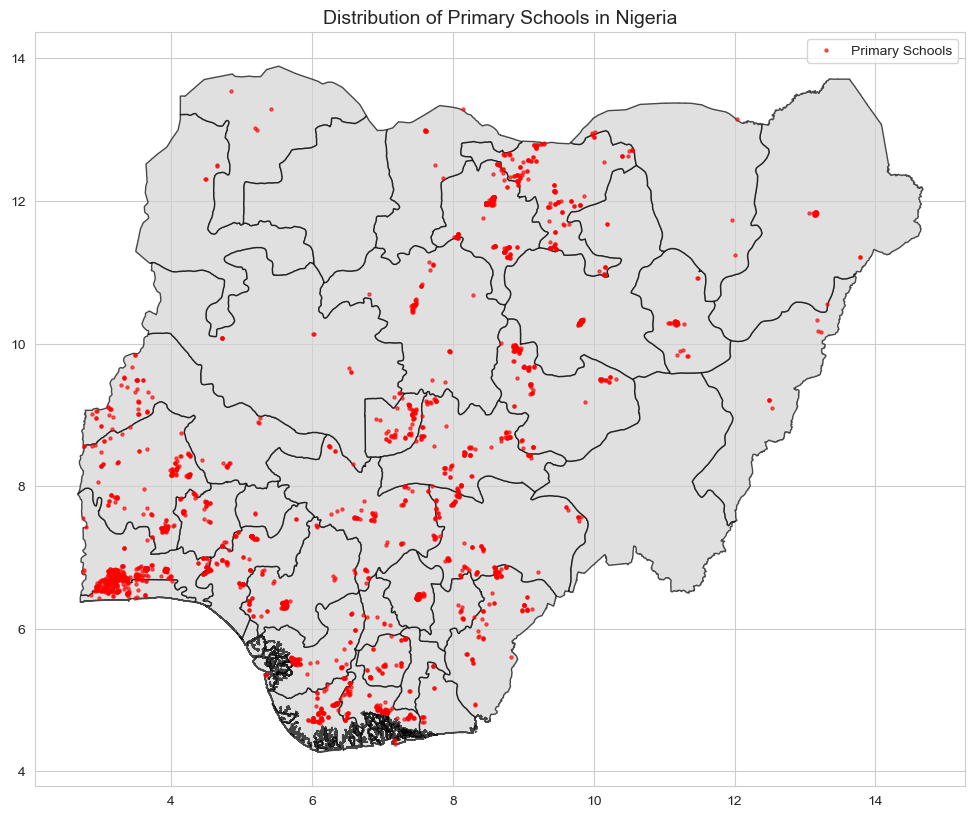

In [ ]:

# Plot Nigeria state boundaries with primary schools
fig, ax = plt.subplots(figsize=(12, 10))
nigeria_boundary.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)

# Plot school locations
Primary_school_data.plot(ax=ax, markersize=5, color='red', alpha=0.6, label="Primary Schools")

# Add title and legend
plt.title("Distribution of Primary Schools in Nigeria", fontsize=14)
plt.legend()
plt.show()


In [ ]:


# ======================
# FULL ANALYSIS PIPELINE
# ======================
def full_analysis(student_df, boundary_file):
    """Complete geospatial analysis pipeline"""
    
    # 1. Prepare student data
    gdf = gpd.GeoDataFrame(
        student_df,
        geometry=gpd.points_from_xy(student_df.Longitude, student_df.Latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)  # Convert to Web Mercator
    


In [ ]:
try:
    boundary = gpd.read_file("Nigeria Boundry Shape file")
except Exception as e:
    print(f"Error loading boundary file: {e}")
    print("Creating convex hull boundary from points instead...")
    boundary = gdf.geometry.unary_union.convex_hull
    boundary = gpd.GeoDataFrame(geometry=[boundary], crs=gdf.crs)

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

def create_education_map(student_df, boundary_path=None, save_path='education_map.png'):
    """
    Create an education access map with robust offline capabilities
    
    Parameters:
    - student_df: DataFrame with 'Longitude' and 'Latitude' columns
    - boundary_path: Optional path to boundary shapefile
    - save_path: Where to save the output image
    """
    
    # 1. Prepare student data
    gdf = gpd.GeoDataFrame(
        student_df,
        geometry=gpd.points_from_xy(student_df.Longitude, student_df.Latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)  # Web Mercator
    
    # 2. Prepare boundary (with fallback to convex hull)
    if boundary_path:
        try:
            boundary = gpd.read_file(boundary_path).to_crs(gdf.crs)
        except Exception as e:
            print(f"Couldn't load boundary file: {e}")
            boundary = gdf.geometry.unary_union.convex_hull
            boundary = gpd.GeoDataFrame(geometry=[boundary], crs=gdf.crs)
    else:
        boundary = gdf.geometry.unary_union.convex_hull
        boundary = gpd.GeoDataFrame(geometry=[boundary], crs=gdf.crs)
    
    # 3. Create plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot boundary
    boundary.boundary.plot(ax=ax, color='gray', linewidth=1, label='Region')
    
    # Plot students - color by cluster if available
    if 'Cluster' in gdf.columns:
        gdf.plot(ax=ax, column='Cluster', legend=True,
                markersize=50, alpha=0.7, cmap='tab20')
    else:
        gdf.plot(ax=ax, color='blue', markersize=50, label='Students')
    
    # 4. Try to add basemap with multiple fallbacks
    providers = [
        ctx.providers.OpenStreetMap.Mapnik,
        ctx.providers.Stamen.TonerLite,
        ctx.providers.Esri.WorldStreetMap
    ]
    
    basemap_added = False
    for provider in providers:
        try:
            ctx.add_basemap(ax, source=provider, timeout=10)
            basemap_added = True
            break
        except Exception as e:
            continue
    
    if not basemap_added:
        ax.set_facecolor('#e6f3ff')  # Light blue background
        print("Couldn't connect to basemap servers - using simple background")
    
    # 5. Finalize and save
    ax.set_title("Education Access Analysis", fontsize=16)
    ax.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Map saved to {save_path}")
    plt.close()
    
    return gdf

In [ ]:
    # 4. Spatial autocorrelation
    from esda.moran import Moran
    from libpysal.weights import DistanceBand
    
    coords = list(zip(gdf.geometry.x, gdf.geometry.y))
    weights = DistanceBand(coords, threshold=50000)  # 50km threshold
    
    moran = Moran(gdf['Home_to_Uni_Distance'], weights)
    print(f"\nSpatial Autocorrelation Results:")
    print(f"Moran's I: {moran.I:.3f} (p-value: {moran.p_norm:.4f})")
    


('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 55, ' is an island (no neighbors)')
('WARNING: ', 97, ' is an island (no neighbors)')
('WARNING: ', 123, ' is an island (no neighbors)')
('WARNING: ', 124, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')

Spatial Autocorrelation Results:
Moran's I: 0.495 (p-value: 0.0000)


c:\Users\Abubakar\anaconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 9 islands with ids: 6, 38, 39, 55, 97, 123, 124, 129, 149.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\Abubakar\anaconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 9 islands with ids: 6, 38, 39, 55, 97, 123, 124, 129, 149.
  W.__init__(


In [ ]:
# 5. Underserved area identification
from sklearn.neighbors import KernelDensity

def underserved_area_analysis(gdf, coords):
    kde = KernelDensity(bandwidth=0.2).fit(coords)
    gdf['access_density'] = np.exp(kde.score_samples(coords))
    
    underserved = gdf[gdf['access_density'] < gdf['access_density'].quantile(0.1)]
    underserved.to_file("underserved_areas.geojson", driver='GeoJSON')
    
    return gdf

# Run analysis
final_gdf = underserved_area_analysis(gdf, coords)

In [ ]:
# ======================
# CREATE VISUALIZATION FOLDER
# ======================
import os
import shutil

# Define folder path
vis_folder = "Final_Visualization"

# Create folder (delete if exists to ensure clean start)
if os.path.exists(vis_folder):
    shutil.rmtree(vis_folder)
os.makedirs(vis_folder)

# Function to save visualization files to the folder
def save_to_vis_folder(filename):
    """Move or save file to visualization folder"""
    # If file exists in current directory, move it
    if os.path.exists(filename):
        shutil.move(filename, os.path.join(vis_folder, filename))
    # Return the new path for saving files directly
    return os.path.join(vis_folder, filename)


In [ ]:

# ======================
# MODIFIED SAVE COMMANDS (replace all existing save commands with these)
# ======================

# For matplotlib figures:
plt.savefig(save_to_vis_folder('cluster_distribution.png'), dpi=300, bbox_inches='tight')
plt.savefig(save_to_vis_folder('education_access_map.png'), dpi=300, bbox_inches='tight')

# For folium maps:
m.save(save_to_vis_folder('student_map_with_legend.html'))
m.save(save_to_vis_folder('jamb_attempts_heatmap.html'))

# For geopandas outputs:
underserved.to_file(save_to_vis_folder("underserved_areas.geojson"), driver='GeoJSON')

# For CSV files:
df.to_csv(save_to_vis_folder("corrected_schools.csv"), index=False)

print(f"\nAll visualizations saved to {vis_folder} folder:")
print(os.listdir(vis_folder))

AttributeError: 'float' object has no attribute 'split'

<Figure size 640x480 with 0 Axes>

In [ ]:

# Create folder (delete if exists to ensure clean start)
if os.path.exists(vis_folder):
    shutil.rmtree(vis_folder)
os.makedirs(vis_folder)

# Function to save visualization files to the folder
def save_to_vis_folder(filename):
    """Move or save file to visualization folder"""
    # If file exists in current directory, move it
    if os.path.exists(filename):
        shutil.move(filename, os.path.join(vis_folder, filename))
    # Return the new path for saving files directly
    return os.path.join(vis_folder, filename)

# ======================
# MODIFIED SAVE COMMANDS (replace all existing save commands with these)
# ======================

# For matplotlib figures:
plt.savefig(save_to_vis_folder('cluster_distribution.png'), dpi=300, bbox_inches='tight')
plt.savefig(save_to_vis_folder('education_access_map.png'), dpi=300, bbox_inches='tight')

# For folium maps:
m.save(save_to_vis_folder('student_map_with_legend.html'))
m.save(save_to_vis_folder('jamb_attempts_heatmap.html'))

# For geopandas outputs:
underserved.to_file(save_to_vis_folder("underserved_areas.geojson"), driver='GeoJSON')

# For CSV files:
df.to_csv(save_to_vis_folder("corrected_schools.csv"), index=False)

print(f"\nAll visualizations saved to {vis_folder} folder:")
print(os.listdir(vis_folder))

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'Final_Visualization\\student_map_with_legend.html'